### Finishing up preparding the emcee for SFH (all 5 parameters), and checking the entire function tree manually

In [4]:
import sys
sys.path.append('/home/samantha/Documents/REU/scripts/') # Use the absolute path to the directory
from prospectFunctionsSFH import *

from matplotlib.pyplot import *
import emcee
import corner

In [130]:
params, obs, sps, wspec = init_prospect_generation()

In [131]:
params

{'zred': 3.548,
 'mass': 100000000.0,
 'logzsol': 0.0,
 'dust2': 0.0,
 'sfh': 1,
 'imf_type': 2,
 'dust_type': 0,
 'tage': 1.0,
 'logtau': -1.0,
 'tau': 0.1,
 'fburst': 0.0,
 'fage_burst': 0.0,
 'tburst': 0.0,
 'const': 0.0,
 'fstart': 0.0,
 'ftrunc': 0.0,
 'sf_start': 0.0,
 'sf_trunc': 0.0}

In [71]:
def sf_trunc_from_ftrunc(tage,ftrunc):
    if ftrunc == 0.:
        return 0.0
    end_trunc = tage * ftrunc
    return tage - end_trunc

In [ ]:
def sf_trunc_from_ftrunc(**sfh):

    pset = getNamespace(**sfh)
    if pset.ftrunc == 0.:
        return 0.0
    start_trunc = pset.tage * pset.fstart
    end_trunc = (pset.tage - start_trunc) * pset.ftrunc
    return pset.tage - end_trunc

In [124]:
# theta = [params['tage'], params['logtau'], params['fburst'], params['fage_burst'], params['const'], params['ftrunc']]
theta = [1.775, 2.0, .2, .6, .5, .1]
theta

[1.775, 2.0, 0.2, 0.6, 0.5, 0.1]

In [125]:
log_prior(theta)

(-inf, [False, True, True, True, True, True])

In [123]:
def log_prior(theta):
    
    tage, logtau, fburst, fage_burst, const, ftrunc = theta

    # This is where all the priors will be set for each parameter in theta
    tage_prior = 0.1 <= tage < 1.775 # Max age is the age of the universe at this redshift
    # tau_prior = 0.1 <= tau <= 1e2 (logspace instead (-1,2), feed into prospector)
    logtau_prior = -1 <= logtau <= 2
    fburst_prior = 0.0 <= fburst <= 1.0
    fage_burst_prior = 0.0 <= fage_burst <= 1.0
    const_prior = 0.0 <= const <= 1.0 - fburst
    ftrunc_prior = 0.0 <= ftrunc < 1.0

    # if tage_prior and tau_prior:
    if tage_prior and logtau_prior and fburst_prior and fage_burst_prior and const_prior and ftrunc_prior:
        return 0.0
    return -np.inf #, [tage_prior, logtau_prior, fburst_prior, fage_burst_prior, const_prior, ftrunc_prior]

In [127]:
from astropy.cosmology import Planck13

Planck13.lookback_time(1100).value - Planck13.lookback_time(params['zred']).value
params['zred'], Planck13.lookback_time(params['zred']).value

(3.548, np.float64(12.020942717524154))

In [1]:
import sys
sys.path.append('/home/samantha/Documents/REU/scripts/') # Use the absolute path to the directory
from prospectFunctionsSFH import *

from matplotlib.pyplot import *
import emcee
import corner

In [2]:
params, obs, sps, wspec = init_prospect_generation()

B, Berr = 6.9, 1.5
data = (B,Berr,params,obs,sps)

nwalkers = 132
niter = 20000
initial = np.array([0.3, 0.0, 0.8, .6, .1, .2]) # tage, logtau, fburst, fage_burst, const, ftrunc

ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

###########################################################################################################################################

sampler_test = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

print("Running burn-in...")
p0, _, _ = sampler_test.run_mcmc(p0, 100, progress=True)

# sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

print('done')

Running burn-in...


100%|██████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Running production...


100%|████████████████████████████████████████████████████████████████| 20000/20000 [1:51:23<00:00,  2.99it/s]

done


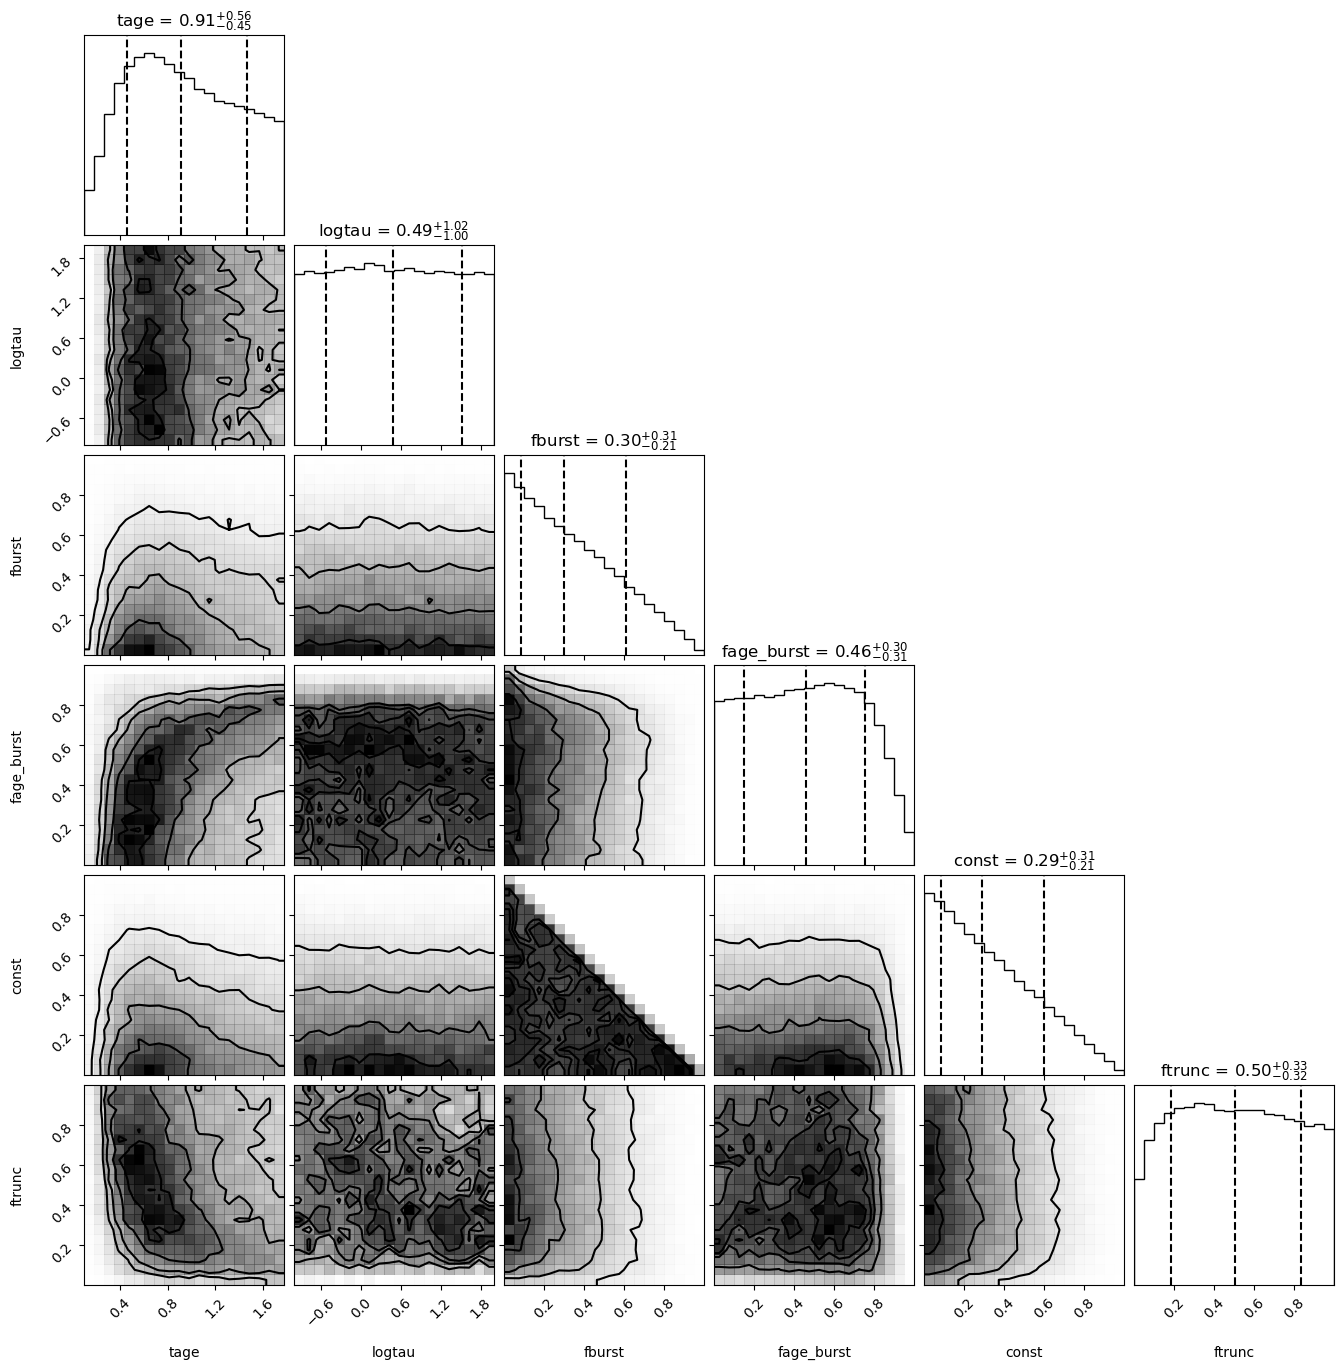

In [60]:
samples=sampler.flatchain

labels = ['tage', 'logtau', 'fburst', 'fage_burst', 'const', 'ftrunc']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=False,quantiles=[0.16, 0.5, 0.84])

# savefig('emcee_sfh_20000.png')

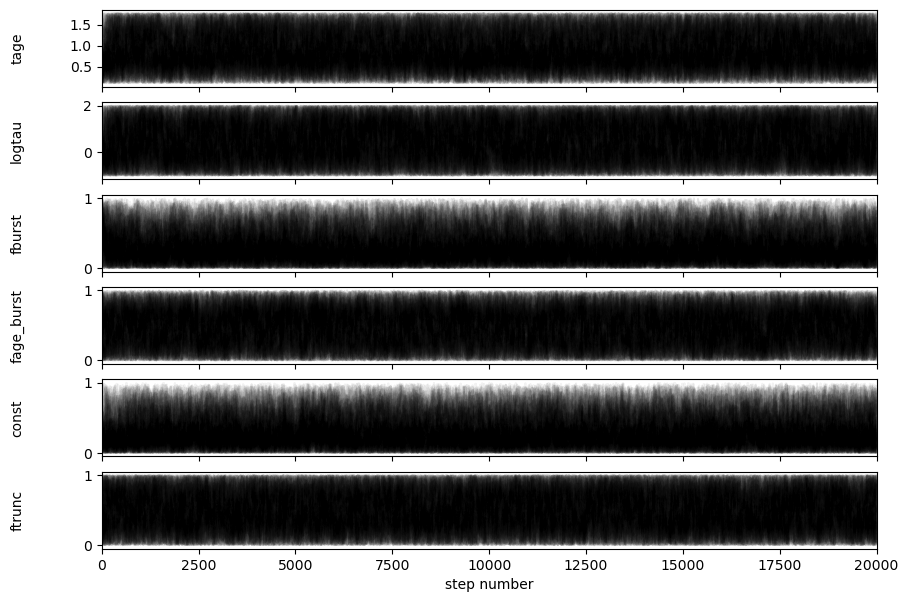

In [59]:
fig, axes = subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.05)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# savefig('samples_chain.png')

In [64]:
spec = getSpec(obs=obs,sps=sps,**params)
compute_break_strength(spec=spec)

np.float64(2.7573109857373614)

In [21]:
params['tau'] = tau_from_logtau(logtau=params['logtau'])

In [49]:
def plot_sfh(params):
    from prospect.plotting.sfh import parametric_sfr
    fig, ax = subplots(figsize=(10,5))
    times = np.linspace(0,params['tage'],10000)
    sfrs = parametric_sfr(times=times,**params)
    ax.plot(times,sfrs,label=f'tage={params['tage']:.2f} Gyrs')

    ax.invert_xaxis()
    ax.set_xlabel('Lookback Time [Gyrs]')
    ax.set_ylabel(r'Star Formation Rate [$M_{\odot}$ $yr^{-1}$]')
    return

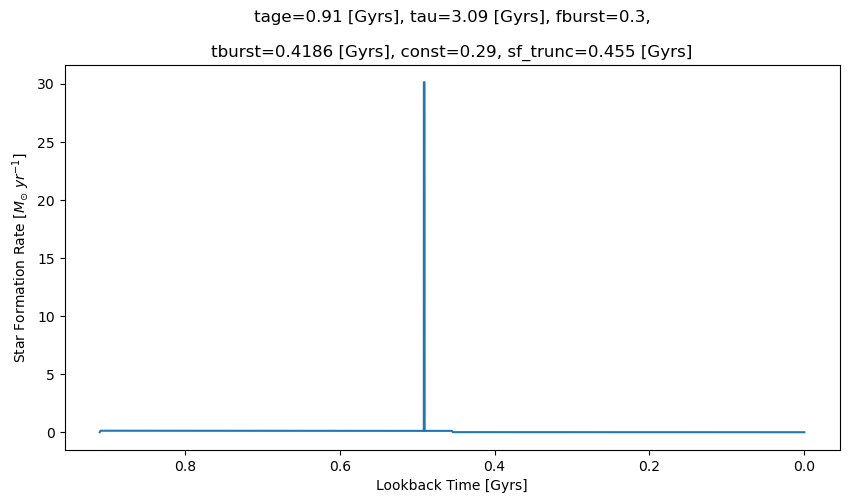

In [52]:
plot_sfh(params)
# title(params)

title_text = {'tage': 0.91,
 # 'logtau': 0.49,
 'tau': 3.09,
 'fburst': 0.3,
 'fage_burst': 0.46,
 'tburst': 0.4186,
 'const': 0.29,
 'sf_trunc': 0.455}

title_text = 'tage=0.91 [Gyrs], tau=3.09 [Gyrs], fburst=0.3,\n\ntburst=0.4186 [Gyrs], const=0.29, sf_trunc=0.455 [Gyrs]'

title(title_text)

# savefig('sfh_20000.png')

show()

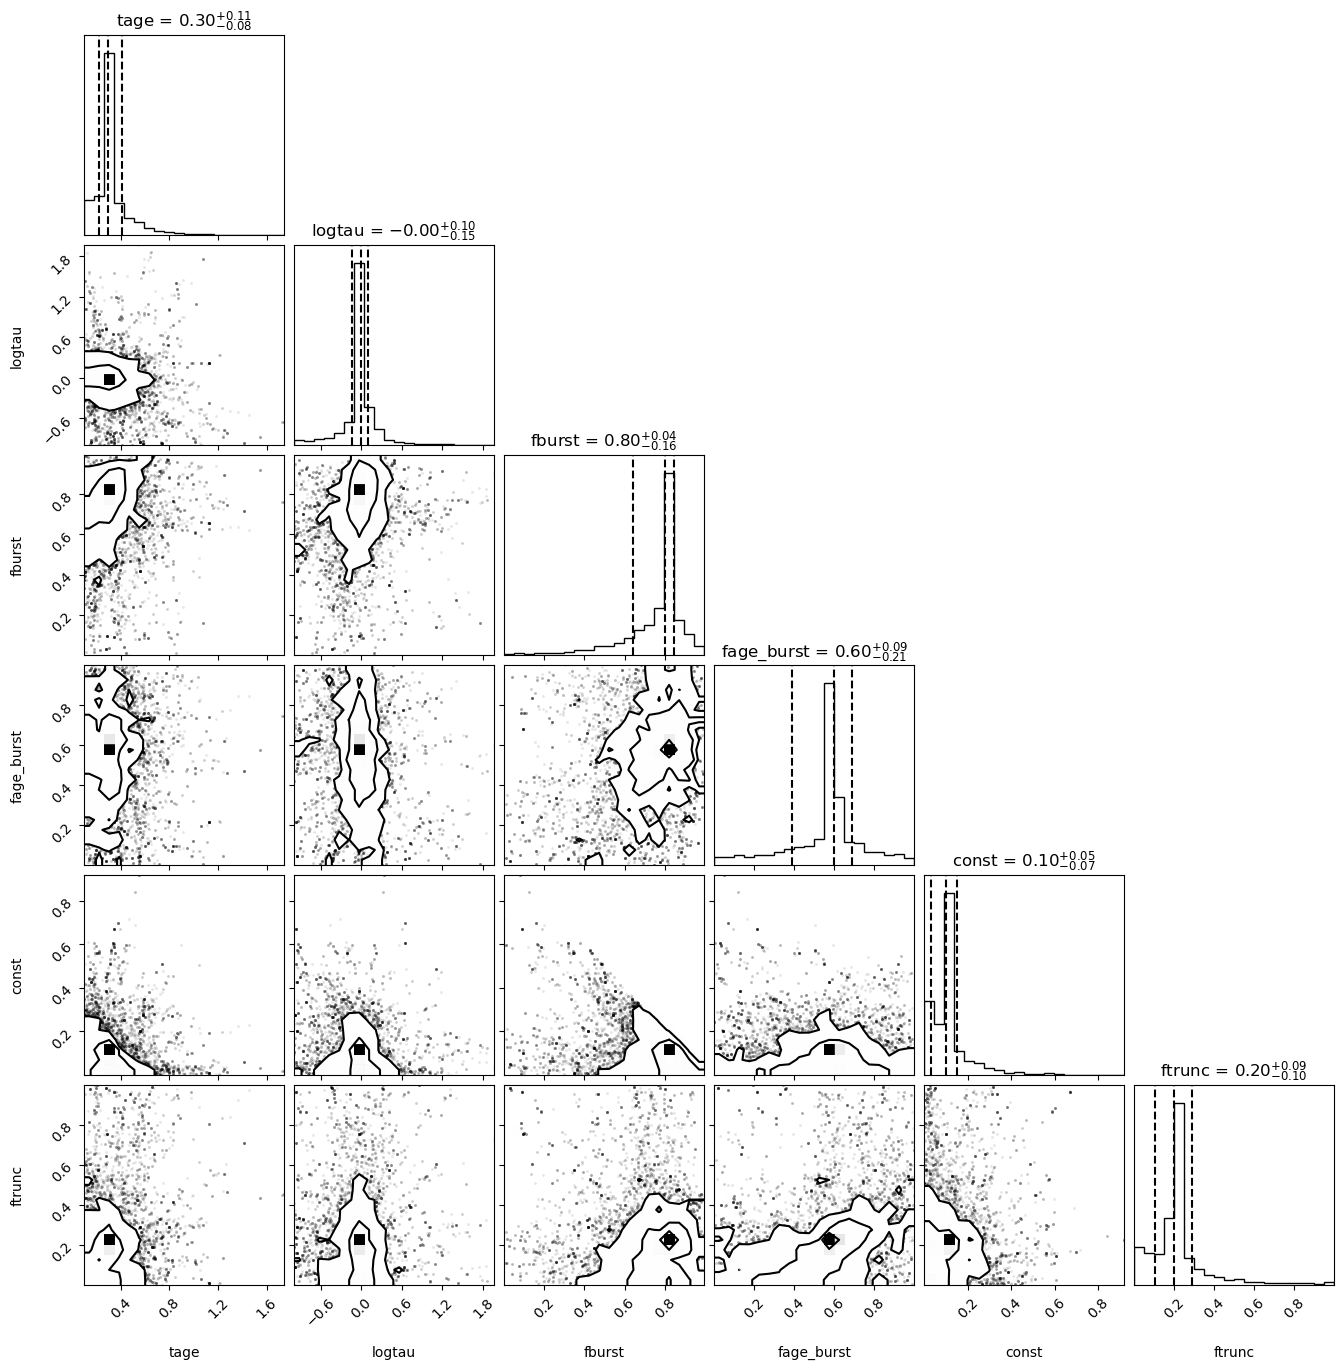

In [7]:
samples=sampler.flatchain

labels = ['tage', 'logtau', 'fburst', 'fage_burst', 'const', 'ftrunc']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

# savefig('burn_in_emcee_sfh.png')